# Usage Journey Analysis Report: Phase-1

## 1. Introduction

### 1.1 Objective of the Analysis

Understand patterns and user segments associated with customer "usage journey" based on variability of usage and average power consumption.

### 1.2 Key Questions to Answer

1. **How many days does it take for a customer to get to each key moment? from activation and first usage**
2. **Is there a difference between purchase date vs. first usage date in terms of long term usage patterns, i.e. "If you're slow to start using it you end up using it rarely"**
3. **Technically is it feasible/easy/hard to do timeline playback, i.e. what would've happened to people each day previously?**


4. **How stable are the usage patterns over time?**


### 1.3 Brief Description of the Dataset used


### 1.4 Scope and limitations

## 2. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import logging
import sshtunnel
import os
import matplotlib.pyplot as plt
import pymysql
import paramiko
from dotenv import load_dotenv
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

/opt/anaconda3/lib/python3.12/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## 3. Data Loading

### 3.1 Database Utils Setup

In [2]:
env_path=os.path.join('.keys', 'keys.env')

if os.path.exists(env_path):
    load_dotenv(env_path)


ssh_host = os.getenv('EC2_IP')
ssh_username = os.getenv('EC2_USER')
ssh_key = os.path.join('.keys','ecook-app-stage-live.pem')


db_host = os.getenv('RDS_HOST')
db_username = os.getenv('RDS_USER')
db_password = os.getenv('RDS_PASSWORD')
db_name = os.getenv('DB_NAME')


'''
with sshtunnel.SSHTunnelForwarder(
    (ssh_host, 22), 
    ssh_username=ssh_username, 
    ssh_pkey=ssh_key, 
    remote_bind_address=(db_host, 3306)
) as tunnel:
    print("Connecton Established", tunnel)
    
    db = pymysql.connect(
        host='127.0.0.1',
        user=db_username,
        passwd=db_password,
        db=db_name,
        port=tunnel.local_bind_port
    )
    with db.cursor() as cur:
        cur.execute("select * from tbl_accounts")
        for r in cur:
             print(r)
    db.close()
'''


def open_ssh_tunnel(verbose=False):
    if verbose:
        sshtunnel.DEFAULT_LOGLEVEL = logging.DEBUG
    global tunnel
    tunnel = sshtunnel.SSHTunnelForwarder(
        (ssh_host, 22),
        ssh_username = ssh_username,
        ssh_pkey = ssh_key,
        remote_bind_address=(db_host, 3306)
    )
    tunnel.start()


def mysql_connect():
    global connection 
    connection = pymysql.connect(
        host='localhost',
        user=db_username,
        passwd=db_password,
        db=db_name,
        port=tunnel.local_bind_port
    )


def run_query(sql):
    return pd.read_sql_query(sql, connection)

def mysql_disconnect():

    connection.close()

def close_ssh_tunnel():
    tunnel.close

In [3]:
open_ssh_tunnel()
mysql_connect()

### 3.2 Data Loading

In [4]:
query = """
    select u.unit_number, u.calendar_date, u.daily_power_consumption, a.registration_date_utc from tbl_daily_compiled_usage_data u
    join tbl_accounts a on a.account_number = u.unit_number
    where a.country = 'Bangladesh'
    and a.account_status IN ('ENABLED', 'UNLOCKED')
    and a.registration_date_utc >= '2023-09-01'
    and u.daily_power_consumption is not null;
    """

In [5]:
df = run_query(query)

### 3.3 Dataset Overview

In [6]:
df.head(3)

unit_number calendar_date  daily_power_consumption registration_date_utc
0    134644111    2024-03-01                     0.10   2024-02-28 18:00:00
1    134644111    2024-03-02                     0.68   2024-02-28 18:00:00
2    134644111    2024-03-03                     3.46   2024-02-28 18:00:00

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624338 entries, 0 to 624337
Data columns (total 4 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   unit_number              624338 non-null  int64         
 1   calendar_date            624338 non-null  object        
 2   daily_power_consumption  624338 non-null  float64       
 3   registration_date_utc    624338 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 19.1+ MB


In [8]:
df.describe()

unit_number  daily_power_consumption          registration_date_utc
count  6.243380e+05            624338.000000                         624338
mean   3.570879e+08                 1.261743  2024-08-09 15:57:13.567513600
min    6.907356e+07                 0.000000            2023-09-02 18:00:00
25%    1.345095e+08                 0.000000            2024-02-19 18:00:00
50%    2.633240e+08                 0.220000            2024-10-11 18:00:00
75%    4.998572e+08                 2.070000            2024-12-09 18:00:00
max    9.289386e+08                31.740000            2025-05-19 11:02:01
std    2.282907e+08                 1.854308                            NaN

### 3.4 Dataset Preprocessing

In [9]:
df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df = df.sort_values(by=['unit_number', 'calendar_date'])
df = df[df['calendar_date']>='2023-09-01']

In [10]:
df.head()

unit_number calendar_date  daily_power_consumption  \
124793     69073559    2024-10-06                     0.09   
124794     69073559    2024-10-07                     0.00   
124795     69073559    2024-10-08                     0.00   
124796     69073559    2024-10-09                     0.00   
124797     69073559    2024-10-10                     0.00   

       registration_date_utc  
124793   2024-10-03 04:39:38  
124794   2024-10-03 04:39:38  
124795   2024-10-03 04:39:38  
124796   2024-10-03 04:39:38  
124797   2024-10-03 04:39:38

In [11]:
mean_df = df.groupby(['unit_number'])['daily_power_consumption'].mean().reset_index()

In [12]:
mean_df.head(3)

unit_number  daily_power_consumption
0     69073559                 2.426842
1     69073658                 3.377469
2     69074557                 2.087396

### 3.5 Defining bounds

ZERO_USER = 0
VERY_LOW_USER = 0.5
LOW_USER = 1.5
MODERATE_USER = 2.0
HIGH_USER = 3.0

In [13]:
ZERO_USER = 0
VERY_LOW_USER = 0.5
LOW_USER = 1.5
MODERATE_USER = 2.0
HIGH_USER = 3.0

In [14]:
def classify_user(consumption):
    if consumption <= ZERO_USER:
        return 'Zero User'
    elif consumption <= VERY_LOW_USER:
        return 'Very Low User'
    elif consumption <= LOW_USER:
        return 'Low User'
    elif consumption <= MODERATE_USER:
        return 'Moderate User'
    elif consumption <= HIGH_USER:
        return 'High User'
    else:
        return 'Very High User'

In [15]:
mean_df['user_category'] = mean_df['daily_power_consumption'].apply(classify_user)

## 4. Analysis

### 4.1 User Segments

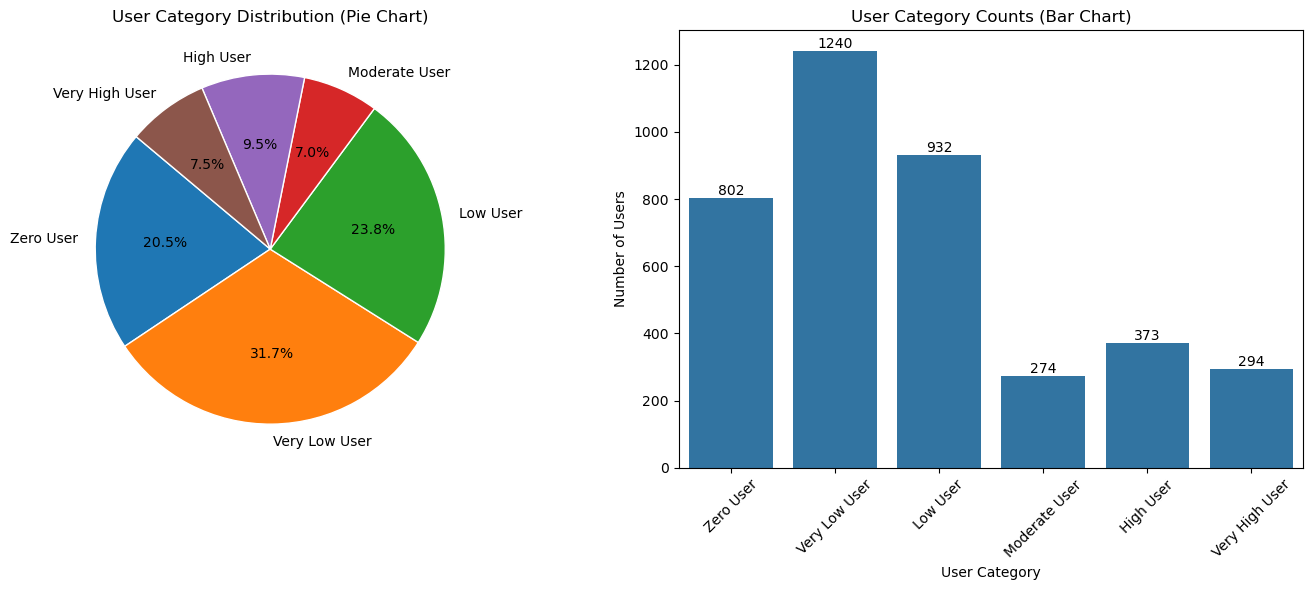

In [16]:
user_order = ['Zero User', 'Very Low User','Low User', 'Moderate User', 'High User', 'Very High User']

mean_df['user_category'] = pd.Categorical(mean_df['user_category'], categories=user_order, ordered=True)

category_counts = mean_df['user_category'].value_counts().loc[user_order]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
axes[0].set_title('User Category Distribution (Pie Chart)')

sns.barplot(
    x=category_counts.index,
    y=category_counts.values,
    ax=axes[1],
    order=user_order 
)
axes[1].set_title('User Category Counts (Bar Chart)')
axes[1].set_xlabel('User Category')
axes[1].set_ylabel('Number of Users')
axes[1].bar_label(axes[1].containers[0])  

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

> This chart shows the distribution of users across six usage categories. The pie chart displays the percentage share of each category, while the bar chart shows the actual number of users in each. Together, they provide a clear view of how user activity is spread in the dataset.

### 4.2 Cluster Journey overtime

In [20]:
def cluster_journey_overtime(user):
    user_df = df[df['unit_number'] == user].copy()

    user_df['month'] = user_df['calendar_date'].dt.to_period('M')

    monthly_behavior = user_df.groupby('month')['daily_power_consumption'].agg(['mean', 'std']).reset_index()
    monthly_behavior = monthly_behavior.fillna(0)

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(monthly_behavior[['mean', 'std']])

    kmeans = KMeans(n_clusters=3, random_state=42)
    monthly_behavior['cluster'] = kmeans.fit_predict(features_scaled)

    fig = px.scatter(
        monthly_behavior,
        x='mean',
        y='std',
        color='cluster',
        text=monthly_behavior['month'].astype(str),
        title=f'User {user}: Cluster Journey Over Time'
    )

    fig.update_traces(textposition='top center')
    fig.update_layout(
        xaxis_title='Average Daily Consumption (kWh)',
        yaxis_title='Usage Variability (kWh)',
        width=900,
        height=600,
        showlegend=True
    )

    fig.add_trace(
        go.Scatter(
            x=monthly_behavior['mean'],
            y=monthly_behavior['std'],
            mode='lines',
            line=dict(color='black', dash='dash'),
            showlegend=False
        )
    )

    fig.show()

#### 4.2.1 Zero Users

In [25]:
cluster_journey_overtime(mean_df[mean_df['user_category'] == 'Zero User']['unit_number'].sample(1).iloc[0])

ValueError: n_samples=1 should be >= n_clusters=3.

#### 4.2.2 Low Users

In [22]:
cluster_journey_overtime(mean_df[mean_df['user_category'] == 'Low User']['unit_number'].sample(1).iloc[0])

#### 4.2.3 Moderate Users

In [ ]:
cluster_journey_overtime(mean_df[mean_df['user_category'] == 'Moderate User']['unit_number'].sample(1).iloc[0])

#### 4.2.4 High Users

In [ ]:
cluster_journey_overtime(mean_df[mean_df['user_category'] == 'High User']['unit_number'].sample(1).iloc[0])

#### 4.2.5 Very High Users

In [ ]:
cluster_journey_overtime(mean_df[mean_df['user_category'] == 'Very High User']['unit_number'].sample(1).iloc[0])

### 4.3 Dynamic Population Cluster Over Time

In [26]:
category_thresholds = {
    'ZERO_USER': 0,
    'VERY_LOW_USER': 0.5,
    'LOW_USER': 1.5,
    'MODERATE_USER': 2.0,
    'HIGH_USER': 3.0
}
usage_colors = {
    'ZERO_USER': 'gray',
    'VERY_LOW_USER': 'green',
    'LOW_USER': 'blue',
    'MODERATE_USER': 'orange',
    'HIGH_USER': 'red'
}

df['weekly_avg'] = df.groupby('unit_number')['daily_power_consumption'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

df['month'] = df['calendar_date'].dt.to_period('M')

all_frames = []
transition_records = []
months = sorted(df['month'].unique())
prev_assignments = {}

for month in months:
    month_df = df[df['month'] == month]

    summary = month_df.groupby('unit_number')['weekly_avg'].agg(['mean', 'std']).reset_index()
    summary = summary.fillna(0)
    summary['month'] = str(month)

    def classify(avg):
        if avg == category_thresholds['ZERO_USER']:
            return 'ZERO_USER'
        elif avg <= category_thresholds['VERY_LOW_USER']:
            return 'VERY_LOW_USER'
        elif avg <= category_thresholds['LOW_USER']:
            return 'LOW_USER'
        elif avg <= category_thresholds['MODERATE_USER']:
            return 'MODERATE_USER'
        else:
            return 'HIGH_USER'

    summary['usage_level'] = summary['mean'].apply(classify)
    summary['color'] = summary['usage_level'].map(usage_colors)

    current_assignments = dict(zip(summary['unit_number'], summary['usage_level']))
    if prev_assignments:
        for uid, new_level in current_assignments.items():
            old_level = prev_assignments.get(uid, None)
            if old_level:
                transition_records.append({
                    'unit_number': uid,
                    'from_month': str(months[months.index(month) - 1]),
                    'to_month': str(month),
                    'from_cluster': old_level,
                    'to_cluster': new_level
                })
    prev_assignments = current_assignments

    cluster_shapes = []
    for label, grp in summary.groupby('usage_level'):
        mean_x = grp['mean'].mean()
        mean_y = grp['std'].mean()
        std_x = grp['mean'].std()
        std_y = grp['std'].std()
        if pd.isna(std_x) or pd.isna(std_y):
            continue
        cluster_shapes.append({
            'label': label,
            'x0': mean_x - std_x * 2,
            'x1': mean_x + std_x * 2,
            'y0': mean_y - std_y * 2,
            'y1': mean_y + std_y * 2,
            'color': usage_colors[label]
        })

    all_frames.append((str(month), summary, cluster_shapes))

initial_month, initial_data, initial_shapes = all_frames[0]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=initial_data['mean'],
    y=initial_data['std'],
    mode='markers',
    marker=dict(color=initial_data['color'], size=8),
    text=initial_data['unit_number'],
    hovertemplate='Unit: %{text}<br>Mean: %{x:.2f}<br>Std: %{y:.2f}'
))

for shape in initial_shapes:
    fig.add_shape(
        type="rect",
        x0=shape['x0'], x1=shape['x1'],
        y0=shape['y0'], y1=shape['y1'],
        fillcolor=shape['color'],
        opacity=0.15,
        line=dict(color=shape['color']),
        layer="below"
    )

frames = []
for month, data, shapes in all_frames:
    scatter = go.Scatter(
        x=data['mean'],
        y=data['std'],
        mode='markers',
        marker=dict(color=data['color'], size=8),
        text=data['unit_number'],
        hovertemplate='Unit: %{text}<br>Mean: %{x:.2f}<br>Std: %{y:.2f}'
    )
    frame_shapes = [
        dict(
            type="rect",
            x0=s['x0'], x1=s['x1'],
            y0=s['y0'], y1=s['y1'],
            fillcolor=s['color'],
            opacity=0.15,
            line=dict(color=s['color']),
            layer="below"
        ) for s in shapes
    ]
    frames.append(go.Frame(data=[scatter], name=month, layout=dict(shapes=frame_shapes)))

fig.frames = frames

fig.update_layout(
    title="Weekly Usage Classification Over Time",
    xaxis_title="Weekly Avg Consumption (kWh)",
    yaxis_title="Usage Variability (Std Dev, kWh)",
    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [None, {
                    "frame": {"duration": 600, "redraw": True},
                    "fromcurrent": True,
                    "mode": "immediate"
                }]
            },
            {
                "label": "Pause",
                "method": "animate",
                "args": [[None], {
                    "frame": {"duration": 0},
                    "mode": "immediate"
                }]
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }],
    sliders=[{
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 16},
            "prefix": "Month: ",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "steps": [{
            "method": "animate",
            "label": month,
            "args": [[month], {
                "frame": {"duration": 0},
                "mode": "immediate"
            }]
        } for month, _, _ in all_frames]
    }]
)

fig.show()

> This animated scatter plot shows how user units transition between different power usage categories over time. Each point represents a unit's average weekly consumption and its variability, color-coded by usage level. The animation helps visualize changes in consumption behavior across months.

### 4.4 Average Population Cluster Level Over Time

In [27]:
df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df['weekly_avg'] = df.groupby('unit_number')['daily_power_consumption'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['weekly_avg'].agg(['mean']).reset_index()
monthly_stats = monthly_stats.fillna(0)

def classify_user(avg):
    if avg == 0:
        return 'ZERO_USER'
    elif avg <= 0.5:
        return 'VERY_LOW_USER'
    elif avg <= 1.5:
        return 'LOW_USER'
    elif avg <= 2.0:
        return 'MODERATE_USER'
    elif avg <= 3.0:
        return 'HIGH_USER'
    else:
        return 'VERY_HIGH_USER'

label_to_level = {
    'ZERO_USER': 0,
    'VERY_LOW_USER': 1,
    'LOW_USER': 2,
    'MODERATE_USER': 3,
    'HIGH_USER': 4,
    'VERY_HIGH_USER': 5
}

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_user)
monthly_stats['level_num'] = monthly_stats['usage_level'].map(label_to_level)

avg_cluster_levels = []
months = sorted(monthly_stats['month'].unique())

for month in months:
    month_data = monthly_stats[monthly_stats['month'] == month]
    avg_level = month_data['level_num'].mean()
    avg_cluster_levels.append({
        'month_str': str(month),
        'avg_level': avg_level
    })

avg_df = pd.DataFrame(avg_cluster_levels)

import plotly.express as px
fig = px.line(
    avg_df,
    x='month_str',
    y='avg_level',
    markers=True,
    title='Average User Category Level Over Time'
)

fig.update_layout(
    yaxis_title='Average Category Level',
    xaxis_title='Month',
    yaxis=dict(
        tickmode='array',
        tickvals=list(label_to_level.values()),
        ticktext=list(label_to_level.keys())
    )
)

fig.show()

> This line chart shows how the average user category level changes over time, month by month. Each point reflects the average usage category (from Zero to Very High) of all units in that month, helping to identify trends in overall consumption behavior across the observed period.

### 4.5 Proportion of Users in User Segments Defined

In [28]:
df['weekly_avg'] = df.groupby('unit_number')['daily_power_consumption'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['weekly_avg'].agg(['mean', 'std', 'max', 'min']).reset_index()
monthly_stats = monthly_stats.fillna(0)

def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Low User'
    elif mean_val <= 1.5:
        return 'Moderate User'
    elif mean_val <= 2.0:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['fixed_usage_level'] = monthly_stats['mean'].apply(classify_fixed)

fixed_cluster_labels = ['Zero User', 'Low User', 'Moderate User', 'High User', 'Very High User']
frames = []

months = sorted(monthly_stats['month'].unique())
for month in months:
    month_data = monthly_stats[monthly_stats['month'] == month]
    level_counts = month_data['fixed_usage_level'].value_counts(normalize=True).reindex(fixed_cluster_labels, fill_value=0)

    for label in fixed_cluster_labels:
        frames.append({
            'month_str': str(month),
            'fixed_usage_level': label,
            'proportion': level_counts[label]
        })

plot_df = pd.DataFrame(frames)

fig = px.line(
    plot_df,
    x='month_str',
    y='proportion',
    color='fixed_usage_level',
    markers=True,
    title='Proportion of Users by Fixed Usage Categories Over Time'
)

fig.update_layout(
    yaxis_title='Proportion of Users',
    xaxis_title='Month',
    yaxis=dict(tickformat=".0%"),
    width=1000,
    height=600,
    legend_title='Usage Level',
    plot_bgcolor='white',
    font=dict(family='Arial', size=14, color='black')
)

fig.update_traces(marker=dict(size=8))

fig.show()

> This line chart tracks the proportion of users in each fixed usage category over time. It shows how the distribution of users across categories like Zero User, Low User, and Very High User changes month by month. This helps reveal shifts in usage patterns.

### 4.6 User Segment Transitions

#### 4.6.1 User Transition Count

In [29]:
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean', 'std', 'max', 'min']).reset_index()
monthly_stats = monthly_stats.fillna(0)

def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Low User'
    elif mean_val <= 1.5:
        return 'Moderate User'
    elif mean_val <= 2.0:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

journey_df = monthly_stats[['unit_number', 'month_str', 'usage_level']].copy()
journey_df = journey_df.sort_values(['unit_number', 'month_str'])

timeline_transitions = []
months = sorted(journey_df['month_str'].unique())

for i in range(len(months) - 1):
    month = months[i]
    next_month = months[i + 1]

    current_df = journey_df[journey_df['month_str'] == month]
    next_df = journey_df[journey_df['month_str'] == next_month]

    merged = pd.merge(current_df, next_df, on='unit_number', suffixes=('_curr', '_next'))

    transition_grp = merged.groupby(['usage_level_curr', 'usage_level_next']).size().reset_index(name='count')
    transition_grp['month_str'] = month

    timeline_transitions.append(transition_grp)

timeline_df = pd.concat(timeline_transitions, ignore_index=True)

pivot_df = timeline_df.pivot_table(
    index='month_str',
    columns=['usage_level_curr', 'usage_level_next'],
    values='count',
    fill_value=0
)

pivot_df.columns = [f"{frm} → {to}" for frm, to in pivot_df.columns]
pivot_df = pivot_df.sort_index()

pivot_df_reset = pivot_df.reset_index().melt(
    id_vars='month_str',
    var_name='transition',
    value_name='count'
)

def classify_transition(transition):
    frm, to = transition.split(' → ')
    if to in ['High User', 'Very High User']:
        return 'Good'
    elif to == 'Moderate User':
        return 'Moderate'
    else:
        return 'Bad'

pivot_df_reset['transition_type'] = pivot_df_reset['transition'].apply(classify_transition)

transition_colors = {
    'Good': 'green',
    'Moderate': 'orange',
    'Bad': 'red'
}

transition_color_map = {}
for idx, row in pivot_df_reset[['transition', 'transition_type']].drop_duplicates().iterrows():
    transition_color_map[row['transition']] = transition_colors[row['transition_type']]

fig = px.area(
    pivot_df_reset,
    x='month_str',
    y='count',
    color='transition',
    title='Timeline of User Transitions Between Fixed Usage Levels (Colored by Transition Quality)',
    labels={
        'month_str': 'Month',
        'count': 'User Count',
        'transition': 'Transition Type'
    },
    color_discrete_map=transition_color_map
)

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='User Count',
    legend_title='Transition Type',
    hovermode='x unified',
    width=1100,
    height=650,
    font=dict(family='Arial', size=14, color='black'),
    plot_bgcolor='white',
    legend_itemclick='toggleothers', 
    legend_itemdoubleclick='toggle'
)

fig.update_traces(marker=dict(size=8))

fig.show()

#### 4.6.2 User Transitions Normalized

In [30]:
# Step 1: Prepare monthly stats
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean', 'std', 'max', 'min']).reset_index()
monthly_stats = monthly_stats.fillna(0)

# Step 2: Assign fixed usage levels
def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Low User'
    elif mean_val <= 1.5:
        return 'Moderate User'
    elif mean_val <= 2.0:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

# Step 3: Prepare journey dataframe
journey_df = monthly_stats[['unit_number', 'month_str', 'usage_level']].copy()
journey_df = journey_df.sort_values(['unit_number', 'month_str'])

# Step 4: Calculate transitions between months (normalized)
timeline_transitions = []
months = sorted(journey_df['month_str'].unique())

for i in range(len(months) - 1):
    month = months[i]
    next_month = months[i + 1]

    current_df = journey_df[journey_df['month_str'] == month]
    next_df = journey_df[journey_df['month_str'] == next_month]

    merged = pd.merge(current_df, next_df, on='unit_number', suffixes=('_curr', '_next'))

    total_users = len(merged)

    transition_grp = merged.groupby(['usage_level_curr', 'usage_level_next']).size().reset_index(name='count')
    transition_grp['proportion'] = transition_grp['count'] / total_users
    transition_grp['month_str'] = month

    timeline_transitions.append(transition_grp)

# Step 5: Pivot and prepare for plotting
timeline_df = pd.concat(timeline_transitions, ignore_index=True)

pivot_df = timeline_df.pivot_table(
    index='month_str',
    columns=['usage_level_curr', 'usage_level_next'],
    values='proportion',
    fill_value=0
)

pivot_df.columns = [f"{frm} → {to}" for frm, to in pivot_df.columns]
pivot_df = pivot_df.sort_index()

# Step 6: Reshape and classify transitions
pivot_df_reset = pivot_df.reset_index().melt(
    id_vars='month_str',
    var_name='transition',
    value_name='proportion'
)

# ----> New: Classify transitions as Good, Moderate, or Bad
def classify_transition(transition):
    frm, to = transition.split(' → ')
    
    if to in ['High User', 'Very High User']:
        return 'Good'
    elif to == 'Moderate User':
        return 'Moderate'
    else:
        return 'Bad'

pivot_df_reset['transition_type'] = pivot_df_reset['transition'].apply(classify_transition)

# Assign colors manually
transition_colors = {
    'Good': 'green',
    'Moderate': 'orange',
    'Bad': 'red'
}

# Create a mapping for each transition individually
transition_color_map = {}
for idx, row in pivot_df_reset[['transition', 'transition_type']].drop_duplicates().iterrows():
    transition_color_map[row['transition']] = transition_colors[row['transition_type']]

# Step 7: Plot with custom colors
fig = px.area(
    pivot_df_reset,
    x='month_str',
    y='proportion',
    color='transition',
    title='Normalized Timeline of User Transitions with Transition Quality Coloring',
    labels={
        'month_str': 'Month',
        'proportion': 'Proportion of Users',
        'transition': 'Transition Type'
    },
    color_discrete_map=transition_color_map
)

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Proportion of Users',
    yaxis_tickformat=".0%",
    legend_title='Transition Type',
    hovermode='x unified',
    width=1100,
    height=650,
    font=dict(family='Arial', size=14, color='black'),
    plot_bgcolor='white',
    legend_itemclick='toggleothers', 
    legend_itemdoubleclick='toggle'
)

fig.update_traces(marker=dict(size=8))

fig.show()

#### 4.6.3 User Transition Based on Initial Group

In [31]:
from plotly.subplots import make_subplots

df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean']).reset_index()
monthly_stats = monthly_stats.fillna(0)

def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= VERY_LOW_USER:
        return 'Very Low User'
    elif mean_val <= LOW_USER:
        return 'Low User'
    elif mean_val <= MODERATE_USER:
        return 'Moderate User'
    elif mean_val <= HIGH_USER:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

first_usage = monthly_stats.sort_values(['unit_number', 'month']).groupby('unit_number').first().reset_index()
first_usage = first_usage[['unit_number', 'usage_level']]
first_usage.columns = ['unit_number', 'initial_usage_level']

journey_df = pd.merge(monthly_stats, first_usage, on='unit_number', how='left')

cohort_df = journey_df.groupby(['initial_usage_level', 'month_str', 'usage_level']).size().reset_index(name='user_count')

initial_groups = cohort_df['initial_usage_level'].unique()
n_rows = len(initial_groups)

fig = make_subplots(
    rows=n_rows,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=[f"Cohort: {group}" for group in initial_groups]
)

color_map = {
    'Zero User': 'lightgray',
    'Low User': 'red',
    'Moderate User': 'orange',
    'High User': 'blue',
    'Very High User': 'green'
}

for idx, group in enumerate(initial_groups, start=1):
    sub_df = cohort_df[cohort_df['initial_usage_level'] == group]

    for usage_level in sub_df['usage_level'].unique():
        usage_data = sub_df[sub_df['usage_level'] == usage_level]

        fig.add_trace(
            go.Scatter(
                x=usage_data['month_str'],
                y=usage_data['user_count'],
                stackgroup='one',
                name=usage_level,
                legendgroup=usage_level,
                showlegend=True if idx == 1 else False,  # Only show legend once
                line=dict(width=0.5),
                fillcolor=color_map.get(usage_level, 'gray')
            ),
            row=idx,
            col=1
        )

fig.update_layout(
    height=300 * n_rows,
    width=1000,
    title_text="Cohort Chart: User Group Transitions Over Time",
    showlegend=True,
    font=dict(family='Arial', size=14),
    plot_bgcolor='white',
    hovermode='x unified'
)

fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Number of Users")

fig.show()

#### 4.6.3b User Transition Based on Initial Group: Normalized

In [64]:
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean']).reset_index()
monthly_stats = monthly_stats.fillna(0)

def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= VERY_LOW_USER:
        return 'Very Low User'
    elif mean_val <= LOW_USER:
        return 'Low User'
    elif mean_val <= MODERATE_USER:
        return 'Moderate User'
    elif mean_val <= HIGH_USER:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

first_usage = monthly_stats.sort_values(['unit_number', 'month']).groupby('unit_number').first().reset_index()
first_usage = first_usage[['unit_number', 'usage_level']]
first_usage.columns = ['unit_number', 'initial_usage_level']

journey_df = pd.merge(monthly_stats, first_usage, on='unit_number', how='left')

cohort_df = journey_df.groupby(['initial_usage_level', 'month_str', 'usage_level']).size().reset_index(name='user_count')

# Normalize to percentage within each cohort group per month
cohort_df['percent'] = cohort_df.groupby(['initial_usage_level', 'month_str'])['user_count'].transform(
    lambda x: (x / x.sum()) * 100
)

initial_groups = cohort_df['initial_usage_level'].unique()
n_rows = len(initial_groups)

fig = make_subplots(
    rows=n_rows,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=[f"Cohort: {group}" for group in initial_groups]
)

color_map = {
    'Zero User': 'lightgray',
    'Very Low User': 'pink',
    'Low User': 'red',
    'Moderate User': 'orange',
    'High User': 'blue',
    'Very High User': 'green'
}

for idx, group in enumerate(initial_groups, start=1):
    sub_df = cohort_df[cohort_df['initial_usage_level'] == group]

    for usage_level in sub_df['usage_level'].unique():
        usage_data = sub_df[sub_df['usage_level'] == usage_level]

        fig.add_trace(
            go.Scatter(
                x=usage_data['month_str'],
                y=usage_data['percent'],
                stackgroup='one',
                name=usage_level,
                legendgroup=usage_level,
                showlegend=True if idx == 1 else False,
                line=dict(width=0.5),
                fillcolor=color_map.get(usage_level, 'gray')
            ),
            row=idx,
            col=1
        )

fig.update_layout(
    height=300 * n_rows,
    width=1000,
    title_text="Normalized Cohort Chart: Percentage of Users by Usage Level Over Time",
    showlegend=True,
    font=dict(family='Arial', size=14),
    plot_bgcolor='white',
    hovermode='x unified'
)

fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Percentage of Users", range=[0, 100])

fig.show()

### 4.7 User Journey Timeline for User

#### Usage Journey Plotting Function

In [32]:
def user_journey(unit):
    df['calendar_date'] = pd.to_datetime(df['calendar_date'])
    df['week_avg'] = df.groupby('unit_number')['daily_power_consumption'].transform(lambda x: x.rolling(7, min_periods=1).mean())
    df['month'] = df['calendar_date'].dt.to_period('M')
    
    user_counts = df.groupby('unit_number')['month'].nunique()
    if user_counts.get(unit, 0) <= 2:
        print(f"User {unit} does not have enough months of data.")
        return

    user_df = df[df['unit_number'] == unit].copy()
    user_df = user_df.groupby('month')['week_avg'].agg(['mean', 'std', 'max', 'min']).reset_index()
    user_df = user_df.fillna(0)

    def classify_fixed(mean_val):
        if mean_val <= ZERO_USER:
            return 'Zero User'
        elif mean_val <= VERY_LOW_USER:
            return 'Very Low User'
        elif mean_val <= LOW_USER:
            return 'Low User'
        elif mean_val <= MODERATE_USER:
            return 'Moderate User'
        elif mean_val <= HIGH_USER:
            return 'High User'
        else:
            return 'Very High User'

    user_df['usage_level'] = user_df['mean'].apply(classify_fixed)
    user_df['month_str'] = user_df['month'].astype(str)

    fixed_order = ['Zero User', 'Very Low User','Low User', 'Moderate User', 'High User', 'Very High User']

    fig = px.line(
        user_df,
        x='month_str',
        y='usage_level',
        markers=True,
        title=f'Usage Journey of User {unit}',
        category_orders={'usage_level': fixed_order}
    )

    fig.update_layout(
        yaxis_title='Usage Category',
        xaxis_title='Month',
        yaxis=dict(categoryorder='array', categoryarray=fixed_order),
        width=900,
        height=500,
        plot_bgcolor='white',
        font=dict(family='Arial', size=14)
    )

    fig.update_traces(marker=dict(size=8))

    fig.show()

#### 4.7.1 Zero User

In [33]:
user_journey(mean_df[mean_df['user_category'] == 'Zero User']['unit_number'].sample(1).iloc[0])

#### 4.7.2 Very Low User

In [34]:
user_journey(mean_df[mean_df['user_category'] == 'Very Low User']['unit_number'].sample(1).iloc[0])

#### 4.7.3 Low User

In [35]:
user_journey(mean_df[mean_df['user_category'] == 'Low User']['unit_number'].sample(1).iloc[0])

#### 4.7.4 Moderate User

In [36]:
user_journey(mean_df[mean_df['user_category'] == 'Moderate User']['unit_number'].sample(1).iloc[0])

#### 4.7.5 High User

In [37]:
user_journey(mean_df[mean_df['user_category'] == 'High User']['unit_number'].sample(1).iloc[0])

#### 4.7.6 Very High User

In [38]:
user_journey(mean_df[mean_df['user_category'] == 'Very High User']['unit_number'].sample(1).iloc[0])

### 4.8 Cohort Charts

In [39]:
df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean']).reset_index()
monthly_stats = monthly_stats.fillna(0)

def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Low User'
    elif mean_val <= 1.5:
        return 'Moderate User'
    elif mean_val <= 2.0:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

high_users = monthly_stats[monthly_stats['usage_level'].isin(['High User', 'Very High User'])]
first_high_month = high_users.groupby('unit_number')['month'].min().reset_index()
first_high_month.columns = ['unit_number', 'first_high_month']

user_journey = pd.merge(monthly_stats, first_high_month, on='unit_number', how='inner')
user_journey = user_journey[user_journey['month'] >= user_journey['first_high_month']]

user_journey['cohort_month'] = user_journey['first_high_month'].astype(str)
user_journey['period'] = (user_journey['month'] - user_journey['first_high_month']).apply(lambda x: x.n)

avg_usage_pivot = user_journey.pivot_table(
    index='cohort_month',
    columns='period',
    values='mean',
    aggfunc='mean'
)

count_pivot = user_journey.pivot_table(
    index='cohort_month',
    columns='period',
    values='mean',
    aggfunc='count'
)

custom_text = avg_usage_pivot.copy()
for row in custom_text.index:
    for col in custom_text.columns:
        avg = avg_usage_pivot.loc[row, col]
        count = count_pivot.loc[row, col] if pd.notna(count_pivot.loc[row, col]) else 0
        if pd.notna(avg):
            custom_text.loc[row, col] = f"{avg:.2f}\n({int(count)})"
        else:
            custom_text.loc[row, col] = ""

fig = px.imshow(
    avg_usage_pivot,
    labels=dict(x="Months Since Becoming High User", y="Cohort Start Month", color="Avg Daily Usage (kWh)"),
    color_continuous_scale=['green', 'yellow', 'red'],
    title='Cohort Heatmap: Avg Usage & User Count'
)

fig.update_traces(
    text=custom_text.values,
    texttemplate="%{text}",
    hovertemplate="Avg Usage: %{z:.2f}<br>%{text}<extra></extra>"
)

fig.update_layout(
    width=1000,
    height=600,
    font=dict(family='Arial', size=14),
    xaxis_title='Months Since Becoming High/Very High User',
    yaxis_title='Cohort Month',
    coloraxis_colorbar=dict(
        title="Avg Daily Usage",
        tickformat=".2f"
    )
)

fig.show()

### 4.9 Rentention Of Users

In [40]:
df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean']).reset_index()
monthly_stats = monthly_stats.fillna(0)

def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Very Low User'
    elif mean_val <= 1.5:
        return 'Low User'
    elif mean_val <= 2.0:
        return 'Moderate User'
    elif mean_val <= 3.0:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

usage_order = {
    'Zero User': 0,
    'Very Low User': 1,
    'Low User': 2,
    'Moderate User': 3,
    'High User': 4,
    'Very High User': 5
}

monthly_stats['level_num'] = monthly_stats['usage_level'].map(usage_order)

category_retention_results = []

for level_name, level_val in usage_order.items():
    eligible = monthly_stats[monthly_stats['level_num'] >= level_val]
    
    first_month = eligible.groupby('unit_number')['month'].min().reset_index()
    first_month.columns = ['unit_number', 'first_level_month']

    user_journey = pd.merge(monthly_stats, first_month, on='unit_number', how='inner')
    user_journey = user_journey[user_journey['month'] >= user_journey['first_level_month']]
    
    user_retention = user_journey.groupby('unit_number')['level_num'].apply(
        lambda x: all(val >= level_val for val in x)
    ).reset_index()
    
    user_retention.columns = ['unit_number', 'retained']
    
    total_users = len(user_retention)
    retained_users = user_retention['retained'].sum()
    retention_rate = retained_users / total_users if total_users > 0 else 0

    category_retention_results.append({
        'category': level_name,
        'min_level': level_val,
        'total_users': total_users,
        'retained_users': retained_users,
        'retention_rate': retention_rate
    })

retention_df = pd.DataFrame(category_retention_results)
retention_df = retention_df.sort_values('min_level')

for _, row in retention_df.iterrows():
    print(f"Category: {row['category']}")
    print(f"  Total Users reaching or exceeding: {row['total_users']}")
    print(f"  Users who stayed: {row['retained_users']}")
    print(f"  Retention Rate: {row['retention_rate']:.2%}")
    print("-" * 40)

Category: Zero User
  Total Users reaching or exceeding: 3915
  Users who stayed: 3915
  Retention Rate: 100.00%
----------------------------------------
Category: Very Low User
  Total Users reaching or exceeding: 3113
  Users who stayed: 2295
  Retention Rate: 73.72%
----------------------------------------
Category: Low User
  Total Users reaching or exceeding: 2273
  Users who stayed: 1649
  Retention Rate: 72.55%
----------------------------------------
Category: Moderate User
  Total Users reaching or exceeding: 1539
  Users who stayed: 845
  Retention Rate: 54.91%
----------------------------------------
Category: High User
  Total Users reaching or exceeding: 1210
  Users who stayed: 551
  Retention Rate: 45.54%
----------------------------------------
Category: Very High User
  Total Users reaching or exceeding: 721
  Users who stayed: 247
  Retention Rate: 34.26%
----------------------------------------


In [41]:
labels = ['Retained (Stayed High/Very High)', 'Dropped (Fell Below High)']
values = [retained_users, total_users - retained_users]

fig_pie = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0)])

fig_pie.update_layout(
    title_text='Overall Retention of High/Very High Users (Pie Chart)',
    font=dict(family='Arial', size=14),
    width=600,
    height=500
)

fig_pie.show()

In [42]:
fig_funnel = go.Figure(go.Funnel(
    y=["Became High/Very High", "Stayed High/Very High"],
    x=[total_users, retained_users],
    textinfo="value+percent previous"
))

fig_funnel.update_layout(
    title='Retention Funnel for High/Very High Users',
    width=600,
    height=500,
    font=dict(family='Arial', size=14),
    plot_bgcolor='white'
)

fig_funnel.show()

Different versions for moderate, high and very high

funnel for new usage groups

In [43]:
def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Very Low User'
    elif mean_val <= 1.5:
        return 'Low User'
    elif mean_val <= 2.0:
        return 'Moderate User'
    elif mean_val <= 3.0:
        return 'High User'
    else:
        return 'Very High User'

usage_order = {
    'Very High User': 5,
    'High User': 4,
    'Moderate User': 3,
    'Low User': 2,
    'Very Low User': 1,
    'Zero User': 0
}
ordered_labels = list(usage_order.keys())[::-1]

df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean']).reset_index()
monthly_stats = monthly_stats.fillna(0)
monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['level_num'] = monthly_stats['usage_level'].map(usage_order)

very_high_users = monthly_stats[monthly_stats['usage_level'] == 'Very High User']['unit_number'].unique()
very_high_df = monthly_stats[monthly_stats['unit_number'].isin(very_high_users)].copy()

first_vh_month = very_high_df[very_high_df['usage_level'] == 'Very High User'].groupby('unit_number')['month'].min().reset_index()
first_vh_month.columns = ['unit_number', 'first_vh_month']

user_journey = pd.merge(very_high_df, first_vh_month, on='unit_number', how='inner')
user_journey = user_journey[user_journey['month'] >= user_journey['first_vh_month']]

funnel_stages = []
total_vh_users = len(first_vh_month)
funnel_stages.append(("Started Very High", total_vh_users))

for level_name in ['High User', 'Moderate User', 'Low User', 'Very Low User', 'Zero User']:
    level_val = usage_order[level_name]

    drop_users = user_journey.groupby('unit_number')['level_num'].apply(
        lambda x: any(val <= level_val for val in x)
    ).reset_index()

    dropped_count = drop_users['level_num'].sum()
    funnel_stages.append((f"Dropped to {level_name} or Lower", dropped_count))

labels, values = zip(*funnel_stages)

fig_funnel = go.Figure(go.Funnel(
    y=labels,
    x=values,
    textinfo="value+percent initial",
    marker={"color": ['#006400', '#228B22', '#BDB76B', '#FFD700', '#FF8C00', '#B22222']}
))

fig_funnel.update_layout(
    title='Downward Funnel: Drop-off from Very High Usage',
    width=700,
    height=600,
    font=dict(family='Arial', size=14),
    plot_bgcolor='white'
)

fig_funnel.show()

### 4.10 Hubspot Data

#### 4.10.1 Dataset Merge

In [44]:
hs = pd.read_csv('hubspot-data.csv')
hs.head(3)

unit_number product_variant family_members  \
0    134644111    eCook Double             4+   
1    134502210    eCook Double             4+   
2    134503218    eCook Single            1-4   

                      cooking_fuel payment_method upfront_or_monthly  \
0                      Natural Gas           Cash            Upfront   
1  Natural Gas;Electric Stove;Wood           Cash            Upfront   
2                             Wood           Cash            Upfront   

  product_condition   occupation    district     sub_district  
0               New  Private Job  Chattogram        Chandgaon  
1               New  Private Job   Narsingdi           Belabo  
2               New  Private Job   Joypurhat  Jaipurhat Sadar

In [45]:
merged_df = pd.merge(
    mean_df,
    hs,
    on='unit_number',
    how='left'
)

merged_df.head(3)

unit_number  daily_power_consumption   user_category product_variant  \
0     69073559                 2.426842       High User    eCook Double   
1     69073658                 3.377469  Very High User    eCook Double   
2     69074557                 2.087396       High User    eCook Double   

  family_members    cooking_fuel payment_method upfront_or_monthly  \
0              4             NaN           Cash            Upfront   
1             4+  Electric Stove           Cash            Upfront   
2              4             NaN           Cash            Upfront   

  product_condition   occupation district sub_district  
0       Refurbished  Private Job  Comilla       Meghna  
1       Refurbished     Business  Gazipur      Gazipur  
2       Refurbished  Private Job  Gazipur      Gazipur

#### 4.10.2 Hubspot Data Analysis

##### Family Size Stacked Bar Chart

In [46]:
family_data = merged_df[['unit_number', 'family_members', 'daily_power_consumption']].dropna()

def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Very Low User'
    elif mean_val <= 1.5:
        return 'Low User'
    elif mean_val <= 2.0:
        return 'Moderate User'
    elif mean_val <= 3.0:
        return 'High User'
    else:
        return 'Very High User'

avg_usage = merged_df.groupby('unit_number')['daily_power_consumption'].mean().reset_index()
avg_usage['user_category'] = avg_usage['daily_power_consumption'].apply(classify_fixed)

family_data = pd.merge(family_data, avg_usage[['unit_number', 'user_category']], on='unit_number', how='inner')

family_summary = family_data.groupby(['family_members', 'user_category']).size().reset_index(name='user_count')

color_map = {
    'Very High User': '#2ca25f',  
    'High User': '#66c2a4',      
    'Moderate User': '#fec44f',  
    'Low User': '#fdae6b',         
    'Very Low User': '#f768a1',   
    'Zero User': '#cb181d'       
}

usage_order = [
    'Very High User',
    'High User',
    'Moderate User',
    'Low User',
    'Very Low User',
    'Zero User'
]


fig = px.bar(
    family_summary,
    x='family_members',
    y='user_count',
    color='user_category',
    title='Family Size Distribution Across Usage Categories',
    labels={'family_members': 'Number of Family Members', 'user_count': 'Number of Users'},
    barmode='stack',
    color_discrete_map=color_map,
    category_orders={'user_category': usage_order}
)

fig.update_layout(
    width=900,
    height=550,
    font=dict(family='Arial', size=14),
    plot_bgcolor='white',
    xaxis_title='Family Members',
    yaxis_title='Number of Users',
    yaxis_tickformat='d',
    legend_title='User Category'
)

fig.update_traces(textposition='none')

fig.show()


##### Stacked Bar: Product Variant Distribution by User Category

In [47]:
fig = px.histogram(
    merged_df.dropna(subset=['product_variant', 'user_category']),
    x='product_variant',
    color='user_category',
    barmode='stack',
    title='Product Variant Usage by User Category',
    labels={'product_variant': 'Product Variant', 'count': 'Number of Users'}
)
fig.show()

##### Box Plot: Family Size by User Category

In [48]:
fig = px.box(
    merged_df.dropna(subset=['family_members']),
    x='user_category',
    y='family_members',
    color='user_category',
    title='Family Size Distribution by User Category',
    labels={'family_members': 'Number of Family Members'}
)
fig.show()

##### Grouped Bar: Payment Method by User Category

In [49]:
fig = px.histogram(
    merged_df.dropna(subset=['payment_method', 'user_category']),
    x='payment_method',
    color='user_category',
    barmode='group',
    title='Payment Method Usage by User Category',
    labels={'payment_method': 'Payment Method'}
)
fig.show()

##### Grouped Bar: Product Condition by User Category

In [50]:
fig = px.histogram(
    merged_df.dropna(subset=['product_condition', 'user_category']),
    x='product_condition',
    color='user_category',
    barmode='group',
    title='Product Condition Distribution by Usage Group',
    labels={'product_condition': 'Product Condition'}
)
fig.show()

##### Treemap: User Category → Occupation → Product Variant

In [51]:
fig = px.treemap(
    merged_df.dropna(subset=['user_category', 'occupation', 'product_variant']),
    path=['user_category', 'occupation', 'product_variant'],
    title='User Category → Occupation → Product Treemap'
)
fig.show()

##### Grouped Bar: Payment Model by User Category

In [52]:
fig = px.histogram(
    merged_df.dropna(subset=['upfront_or_monthly', 'user_category']),
    x='upfront_or_monthly',
    color='user_category',
    barmode='group',
    title='Upfront vs Monthly by User Category',
    labels={'upfront_or_monthly': 'Payment Plan'}
)
fig.show()

##### Stacked Bar: User Category Breakdown Within Payment Models

In [53]:
fig = px.histogram(
    merged_df.dropna(subset=['upfront_or_monthly', 'user_category']),
    x='user_category',
    color='upfront_or_monthly',
    barmode='stack',
    title='User Category Breakdown by Payment Plan',
    labels={'user_category': 'User Category', 'upfront_or_monthly': 'Payment Model'}
)
fig.show()

##### Pie Charts: Payment Model Split per User Category

In [54]:
fig = px.pie(
    merged_df.dropna(subset=['upfront_or_monthly', 'user_category']),
    names='upfront_or_monthly',
    facet_col='user_category',
    title='Payment Plan Preference Across Usage Categories',
    hole=0.3
)
fig.show()

##### Sunburst: User Category → Payment Plan → Product Variant

In [55]:
fig = px.sunburst(
    merged_df.dropna(subset=['user_category', 'upfront_or_monthly', 'product_variant']),
    path=['user_category', 'upfront_or_monthly', 'product_variant'],
    title='Sunburst: Usage → Payment Plan → Product'
)
fig.show()

##### Parallel Categories: How Payment Plan Intersects With Other Attributes

In [56]:
fig = px.parallel_categories(
    merged_df.dropna(subset=['upfront_or_monthly', 'payment_method', 'product_condition', 'user_category']),
    dimensions=['user_category', 'upfront_or_monthly', 'payment_method', 'product_condition'],
    title='Pathways Through Payment Model and User Traits'
)
fig.show()

##### Clean Cooking Fuel Data

In [57]:
def clean_primary_fuel(row):
    if pd.isna(row):
        return 'Unknown'

    fuels = sorted(set(f.strip() for f in row.split(';')))
    
    fuel_priority = [
        'LPG', 'Electric Stove', 'Magnetic Induction Stove',
        'Natural Gas', 'Biogas', 'Charcoal', 'Butane', 'Wood'
    ]
    
    for preferred in fuel_priority:
        if preferred in fuels:
            return preferred
    
    return 'Mixed'

def classify_fuel_combo(row):
    if pd.isna(row):
        return 'Unknown'

    fuels = set(f.strip() for f in row.split(';'))

    if len(fuels) == 1:
        return f'Only {list(fuels)[0]}'
    elif 'LPG' in fuels and len(fuels) == 2:
        return 'LPG + One Other'
    elif 'LPG' in fuels:
        return 'LPG + Others'
    elif 'Wood' in fuels:
        return 'Wood + Others'
    elif 'Electric Stove' in fuels:
        return 'Electric Stove + Others'
    else:
        return 'Mixed/Other'

merged_df['cooking_fuel_primary'] = merged_df['cooking_fuel'].apply(clean_primary_fuel)
merged_df['cooking_fuel_combo'] = merged_df['cooking_fuel'].apply(classify_fuel_combo)

##### Stacked Bar: Primary Cooking Fuel by User Category

In [58]:
fig = px.histogram(
    merged_df.dropna(subset=['cooking_fuel_primary', 'user_category']),
    x='user_category',
    color='cooking_fuel_primary',
    barmode='stack',
    title='Primary Cooking Fuel Distribution by User Category',
    labels={'user_category': 'Usage Category', 'cooking_fuel_primary': 'Primary Cooking Fuel'}
)
fig.show()

##### Stacked Bar: User Category Composition by District

In [59]:
fig = px.histogram(
    merged_df.dropna(subset=['district', 'user_category']),
    x='district',
    color='user_category',
    barmode='stack',
    title='User Category Composition by District',
    labels={'district': 'District', 'count': 'Number of Users'}
)
fig.show()

##### Bar Chart: Average Daily Power Consumption by District

In [60]:
avg_power = merged_df.groupby('district')['daily_power_consumption'].mean().reset_index()

fig = px.bar(
    avg_power.sort_values('daily_power_consumption', ascending=False),
    x='district',
    y='daily_power_consumption',
    title='Average Daily Power Consumption by District (kWh)',
    labels={'daily_power_consumption': 'Avg kWh'}
)
fig.show()

##### Stacked Bar: Product Variant Use by District

In [61]:
fig = px.histogram(
    merged_df.dropna(subset=['district', 'product_variant']),
    x='district',
    color='product_variant',
    barmode='stack',
    title='Product Variant Usage by District'
)
fig.show()

##### Grouped Bar: Payment Plan (Upfront vs Monthly) by District

In [62]:
fig = px.histogram(
    merged_df.dropna(subset=['district', 'upfront_or_monthly']),
    x='district',
    color='upfront_or_monthly',
    barmode='group',
    title='Payment Plan Preference by District'
)
fig.show()

##### Treemap: District → User Category → Product Variant

In [63]:
fig = px.treemap(
    merged_df.dropna(subset=['district', 'user_category', 'product_variant']),
    path=['district', 'user_category', 'product_variant'],
    title='District → Usage → Product Treemap'
)
fig.show()